# Vector similarity

We can measure the similarity between two vectors using the cosine similarity metric. 


In [1]:
# Load in vector embeddings for 1000 most common words
import json

try:
    with open('data/words_text-embedding-ada-002.json') as f:
        vectors_ada2 = json.load(f)
except json.JSONDecodeError as e:
    print(f"Error loading vectors_ada2: {e}")
    vectors_ada2 = {}

try:
    with open('data/words_text-embedding-3-small-1536.json') as f:
        vectors_emb3 = json.load(f)
except json.JSONDecodeError as e:
    print(f"Error loading vectors_emb3: {e}")
    vectors_emb3 = {}

In [2]:
def cosine_similarity(v1, v2):

  dot_product = sum(
    [a * b for a, b in zip(v1, v2)])
  
  magnitude = (
    sum([a**2 for a in v1]) *
    sum([a**2 for a in v2])) ** 0.5

  return dot_product / magnitude

In [3]:
cosine_similarity(vectors_emb3['dog'], vectors_emb3['cat'])

0.6025387572540716

## Most similar words

We can find the most similar words to a given word using the cosine similarity metric.

In [4]:
import pandas as pd

def most_similar(word: str, vectors: dict) -> list[list]:
    """Return the 10 most similar words and similarities to the given word"""
    word_vector = vectors[word]
    similarities = {w: cosine_similarity(word_vector, vector) for w, vector in vectors.items()}
    most_similar_words = sorted(similarities, key=similarities.get, reverse=True)
    return pd.DataFrame([(word, similarities[word]) for word in most_similar_words[:10]], columns=['word', 'similarity'])


In [5]:
word = 'dog'
most_similar(word, vectors_ada2)

,word,similarity
0,dog,1.000000
1,animal,0.885472
2,god,0.865986
3,cat,0.863493
4,fish,0.856640
5,bird,0.855640
6,diet,0.852973
7,horse,0.852069
8,drug,0.850611
9,gun,0.849355


In [6]:
most_similar(word, vectors_emb3)

,word,similarity
0,dog,1.000000
1,animal,0.681331
2,horse,0.674941
3,cat,0.602539
4,boy,0.556805
5,man,0.531099
6,child,0.522607
7,bird,0.510155
8,door,0.480681
9,baby,0.473690


## Visualizations of similarity space

We can visualize the word vectors in 2D space using dimensionality reduction techniques like PCA (Principal Components Analysis). This allows us to see the relationships between words and how they cluster together. _Note that dimensionality reduction is a very lossy process!_

In [7]:

import numpy as np
from sklearn.decomposition import PCA


def perform_pca(vectors: dict):
    """Perform PCA on the word vectors and return the PCA-transformed vectors"""
    X = np.array(list(vectors.values()))
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)
    X_pca = {list(vectors.keys())[i]: X_pca[i] for i in range(len(vectors))}
    return X_pca


vectors_ada2_pca = perform_pca(vectors_ada2)
vectors_emb3_pca = perform_pca(vectors_emb3)

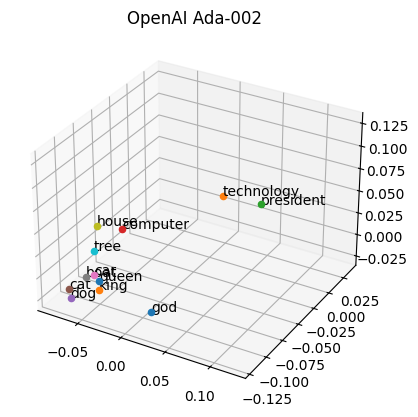

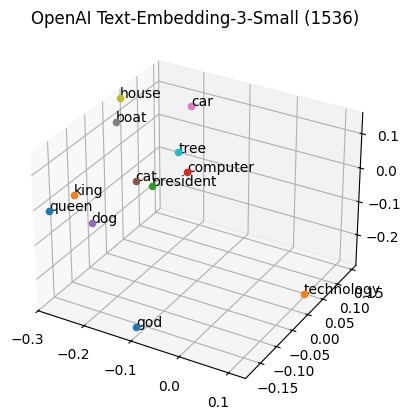

In [8]:
import matplotlib.pyplot as plt

def render_vectors_3d(vectors: dict, title: str):
    """Render 3-dimensional vectors (key: [,,,]) in a 3D plot"""
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # Plot the vectors as points
    for key, vector in vectors.items():
        ax.scatter(vector[0], vector[1], vector[2])
        ax.text(vector[0], vector[1], vector[2], key)

    # Figure out the max and min values for each dimension
    min_x = min(v[0] for v in vectors.values())
    max_x = max(v[0] for v in vectors.values())
    min_y = min(v[1] for v in vectors.values())
    max_y = max(v[1] for v in vectors.values())
    min_z = min(v[2] for v in vectors.values())
    max_z = max(v[2] for v in vectors.values())
    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_y, max_y])
    ax.set_zlim([min_z, max_z])
    ax.set_title(title)
    plt.show()


# Get subset of the vectors for plotting
words = ['queen', 'king', 'president', 'computer', 'dog', 'cat', 'car', 'boat', 'house', 'tree', 'god', 'technology']
word_pca_vectors_ada2 = {word: vectors_ada2_pca[word] for word in words}
word_pca_vectors_emb3 = {word: vectors_emb3_pca[word] for word in words}

# Plot the vectors
render_vectors_3d(word_pca_vectors_ada2, 'OpenAI Ada-002')
render_vectors_3d(word_pca_vectors_emb3, 'OpenAI Text-Embedding-3-Small (1536)')

## Range of similarity values

Each embedding model has a different range of similarity values, so you should not assume that a similarity of 0.5 in one model is the same as a similarity of 0.5 in another model. Always check the range of similarity values for the model you are using.

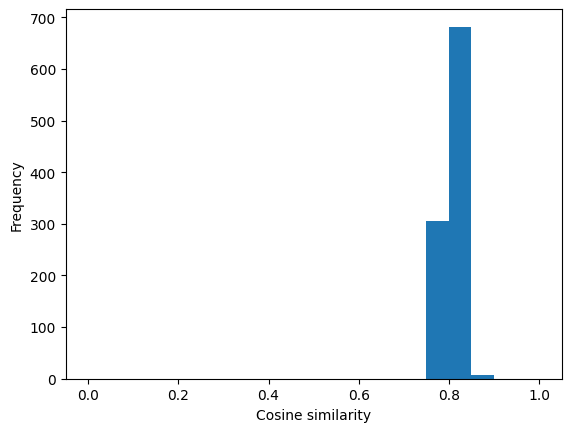

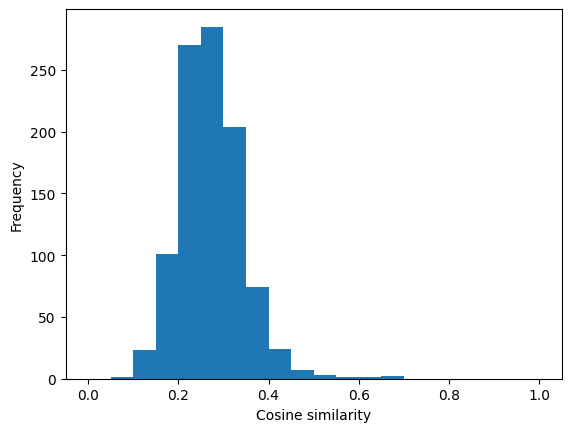

In [9]:
def cosine_similarity_histogram(word: str, vectors: dict):
    """Plot a histogram of the cosine similarities of the word to all other words"""
    word_vector = vectors[word]
    similarities = [cosine_similarity(word_vector, vectors[w]) for w in vectors if w != word]
    plt.hist(similarities, bins=20, range=(0, 1))
    plt.xlabel('Cosine similarity')
    plt.ylabel('Frequency')
    plt.show()

word = 'dog'
cosine_similarity_histogram(word, vectors_ada2)
cosine_similarity_histogram(word, vectors_emb3)

## Explore multi-word vectors

In [10]:
import json

with open('data/movies_text-embedding-3-small-1536.json') as f:
    movies = json.load(f)

In [11]:
# Find the 10 most similar movies to a target movie
target_movie = movies['101 Dalmatians']

# Calculate the cosine similarity between the target movie and all other movies
similarities = [cosine_similarity(target_movie, movie) for movie in movies.values()]

most_similar = sorted(range(len(similarities)), key=lambda i: similarities[i], reverse=True)[1:11]

similar_movies = [(list(movies.keys())[i], round(similarities[i], 3)) for i in most_similar]
pd.DataFrame(similar_movies, columns=['movie', 'similarity'])

,movie,similarity
0,102 Dalmatians,0.887
1,The Aristocats,0.540
2,Snow Dogs,0.478
3,Beverly Hills Chihuahua,0.456
4,The Fox and the Hound,0.449
5,Old Dogs,0.442
6,The Rescuers,0.438
7,That Darn Cat,0.431
8,Lady and the Tramp,0.427
9,The Rescuers Down Under,0.425


In [12]:
# Display the 10 least similar movies
least_similar = sorted(range(len(similarities)), key=lambda i: similarities[i])[1:11]
similar_movies = [(list(movies.keys())[i], round(similarities[i], 3)) for i in least_similar]
pd.DataFrame(similar_movies, columns=['movie', 'similarity'])

,movie,similarity
0,Mumford,0.079
1,Renaissance Man,0.080
2,Phenomenon,0.083
3,Hauru no ugoku shiro,0.089
4,Jefferson in Paris,0.092
5,Hidalgo,0.095
6,Son in Law,0.095
7,Medicine Man,0.104
8,Haakon Haakonsen,0.105
9,Un indien dans la ville,0.107


## Resources

* [Embedding projector](https://projector.tensorflow.org/)
* [Why are Cosine Similarities of Text embeddings almost always positive?](https://vaibhavgarg1982.medium.com/why-are-cosine-similarities-of-text-embeddings-almost-always-positive-6bd31eaee4d5)
* [Expected Angular Differences in Embedding Random Text?](https://community.openai.com/t/expected-angular-differences-in-embedding-random-text/28577)
* [Embeddings: What they are and why they matter](https://simonwillison.net/2023/Oct/23/embeddings/)
